Neural Network Autoencoder
=======

Libraries

In [43]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import time

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_fscore_support, auc

from bayes_opt import BayesianOptimization

from scipy import interp

__Read Data:__

In [2]:
data = pd.read_csv("/media/juanan/DATA/loan_data_analysis/data/loans_processed.csv", sep = "^")\
                   .sample(100000)

In [3]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
751208,1.0,4.0,C,29090.0,0.0,17.0,0.0,7075.0,0.0,14160.0,...,0.0,13316.0,94.200,100.000,C4,4.0,8.0,10.76,OWN,0.0
64172,1.0,1.0,B,5048.0,1.0,23.0,0.0,8000.0,0.0,20193.0,...,0.0,30515.0,56.400,0.000,B1,0.0,5.0,16.39,OWN,0.0
376010,0.0,3.0,B,12555.0,0.0,10.0,0.0,8500.0,0.0,87885.0,...,0.0,89660.0,8.995,8.995,B3,2.0,4.0,20.64,MORTGAGE,0.0
714769,7.0,10.0,C,39454.0,0.0,17.0,0.0,35000.0,0.0,72189.0,...,0.0,43385.0,83.000,57.100,C3,7.0,14.0,15.35,MORTGAGE,0.0
723851,2.0,3.0,C,20907.0,0.0,7.0,0.0,17500.0,0.0,31572.0,...,0.0,19500.0,96.900,100.000,C2,2.0,4.0,15.61,MORTGAGE,0.0


In [4]:
data.shape

(100000, 50)

__Pre-processing__:

Normalization:

In [5]:
numeric_variables = data.loc[:,data.columns != "loan_status"]._get_numeric_data().columns

In [6]:
scaler = MinMaxScaler()

In [7]:
scaler.fit(data[numeric_variables])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
data[numeric_variables] = scaler.transform(data[numeric_variables])

In [9]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
751208,0.004810,0.019240,C,0.082251,0.00000,0.077330,0.0,0.176875,0.0,0.007467,...,0.0,0.013650,0.277385,0.480989,C4,0.019240,0.038479,0.073876,OWN,0.0
64172,0.004810,0.004810,B,0.014273,0.00481,0.106329,0.0,0.200000,0.0,0.010648,...,0.0,0.031279,0.166078,0.000000,B1,0.000000,0.024049,0.112530,OWN,0.0
376010,0.000000,0.014430,B,0.035499,0.00000,0.043498,0.0,0.212500,0.0,0.046342,...,0.0,0.091906,0.026487,0.043265,B3,0.009620,0.019240,0.141710,MORTGAGE,0.0
714769,0.033669,0.048099,C,0.111554,0.00000,0.077330,0.0,0.875000,0.0,0.038065,...,0.0,0.044472,0.244405,0.274645,C3,0.033669,0.067338,0.105390,MORTGAGE,0.0
723851,0.009620,0.014430,C,0.059114,0.00000,0.028999,0.0,0.437500,0.0,0.016648,...,0.0,0.019989,0.285336,0.480989,C2,0.009620,0.019240,0.107175,MORTGAGE,0.0


Categorical Variables:

In [10]:
categorical_variables = data.select_dtypes(include="object").columns

In [11]:
def categorical_to_numeric(variable):
    
    variable_dict = dict(data.groupby(variable)['loan_status'].mean())
    
    result = data[variable].map(lambda i: variable_dict[i])
    
    return result

In [12]:
for variable in categorical_variables:
    data[variable] = categorical_to_numeric(variable)

In [13]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
751208,0.004810,0.019240,0.226533,0.082251,0.00000,0.077330,0.0,0.176875,0.0,0.007467,...,0.0,0.013650,0.277385,0.480989,0.266459,0.019240,0.038479,0.073876,0.217288,0.0
64172,0.004810,0.004810,0.130214,0.014273,0.00481,0.106329,0.0,0.200000,0.0,0.010648,...,0.0,0.031279,0.166078,0.000000,0.103118,0.000000,0.024049,0.112530,0.217288,0.0
376010,0.000000,0.014430,0.130214,0.035499,0.00000,0.043498,0.0,0.212500,0.0,0.046342,...,0.0,0.091906,0.026487,0.043265,0.121829,0.009620,0.019240,0.141710,0.176094,0.0
714769,0.033669,0.048099,0.226533,0.111554,0.00000,0.077330,0.0,0.875000,0.0,0.038065,...,0.0,0.044472,0.244405,0.274645,0.224723,0.033669,0.067338,0.105390,0.176094,0.0
723851,0.009620,0.014430,0.226533,0.059114,0.00000,0.028999,0.0,0.437500,0.0,0.016648,...,0.0,0.019989,0.285336,0.480989,0.205897,0.009620,0.019240,0.107175,0.176094,0.0


In [14]:
data.shape

(100000, 50)

Target:

In [15]:
X = data.loc[:, data.columns!='loan_status']

In [16]:
y = data.reset_index()['loan_status']

__Neural Network Autoencoder and Logistic Regression__: 
====
_____________________

### Bayesian Optimization:

In this model, we are going to use bayesian optimization for hyperparameter tuning. There is an open source implementation in github (https://github.com/fmfn/BayesianOptimization) which is used in this project. Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. 

As you iterate over and over, the algorithm balances its needs of exploration and exploitation taking into account what it knows about the target function. At each step a Gaussian Process is fitted to the known samples (points previously explored), and the posterior distribution, combined with a exploration strategy (such as UCB (Upper Confidence Bound), or EI (Expected Improvement)), are used to determine the next point that should be explored.

We have chosen this method since it is adequate for situations where sampling the function to be optimized is a very expensive endeavor such an autoencoder neural network can be. To do so, this method uses a proxy optimization problem (finding the maximum of the acquisition function) that, albeit still a hard problem, is cheaper (in the computational sense) and common tools can be employed.

Parameters for optimization:

In [17]:
autoencoder_params_bay = {'learning_rate': (1e-5, 0.01),
                          'n_hidden_1': (25, 300),
                          'n_hidden_2': (5, 200)}

According to the documentation of the Bayesian Optimization repository, we need a function with the parameters we want to tune as inputs and this function should returns the metric we want to optimize.

Evaluate function for __Bayesian Optimization__:

In [18]:
def autoencoder_evaluate(learning_rate, n_hidden_1, n_hidden_2):
    
    # parameters
    epochs = 100
    batch_size = 64
    n_hidden_1 = int(n_hidden_1)
    n_hidden_2 = int(n_hidden_2)
    
    # batch size split
    X_split = X.values

    num_batches = int(X_split.shape[0] / batch_size)
    X_split = np.array_split(X_split, num_batches)
    
    ## NEURAL NETWORK ARCHITECTURE
    # hidden layers
    _, number_of_variables = np.shape(X_split[0])
    num_hidden_0 = number_of_variables
    num_hidden_1 = n_hidden_1
    num_hidden_2 = n_hidden_2

    #with tf.device('/cpu:0'):
    x = tf.placeholder(dtype = tf.float64, shape = [None, num_hidden_0])

    weights = {
        # encoder
        'w1': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_0, num_hidden_1], 
                                              dtype=tf.float64)),
        'w2': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_1, num_hidden_2], 
                                              dtype=tf.float64)),
        # decoder
        'w3': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_2, num_hidden_1], 
                                              dtype=tf.float64)),
        'w4': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_1, num_hidden_0], 
                                              dtype=tf.float64)),
    }

    biases = {
        # encoder
        'b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
        'b2': tf.Variable(tf.random_normal([num_hidden_2], dtype=tf.float64)),
        # decoder
        'b3': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
        'b4': tf.Variable(tf.random_normal([num_hidden_0], dtype=tf.float64)),
    }

    #with tf.device('/gpu:0'):
    hidden_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['w1']), biases['b1']))
    hidden_2 = tf.nn.sigmoid(tf.add(tf.matmul(hidden_1, weights['w2']), biases['b2']))
    hidden_3 = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, weights['w3']), biases['b3']))
    autoencoded = tf.nn.sigmoid(tf.add(tf.matmul(hidden_3, weights['w4']), biases['b4']))

    # loss funciton
    loss = tf.reduce_mean(tf.pow(x - autoencoded, 2))
    
    # optimizer
    optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    ## TENSORFLOW SESSION
    init = tf.global_variables_initializer()

    with tf.Session() as session:

        session.run(init)

        for epoch in range(epochs):
            for x_batch in X_split:
                _, eval_loss = session.run([optimize, loss],
                                           feed_dict={x: x_batch})

        # Encoded Input
        X_encoded = session.run([hidden_2], feed_dict = {x: X})
    
    ## LOGISTIC REGRESSION MODEL
    # pre-processing data
    x_encoded = pd.DataFrame(X_encoded[0])
    
    X_train, X_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.8)
    
    # model
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    
    ## EVALUATION
    # scores
    y_scores_train = pd.DataFrame(logistic_regression.predict_proba(X_train)).loc[:,1]
    y_scores_test = pd.DataFrame(logistic_regression.predict_proba(X_test)).loc[:,1]
    
    # auc
    auc_train = roc_auc_score(y_train, y_scores_train)
    auc_test = roc_auc_score(y_test, y_scores_test)
    
    return auc_test

Bayesian Optimization:

In [19]:
bay_optimization = BayesianOptimization(autoencoder_evaluate, autoencoder_params_bay)

In [20]:
bay_optimization.maximize()

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   n_hidden_1 |   n_hidden_2 | 
    1 | 09m45s |    0.82762 |          0.0088 |     212.9070 |      18.1347 | 
    2 | 07m49s |    0.82983 |          0.0027 |      49.6882 |     128.8318 | 
    3 | 19m37s |    0.83074 |          0.0004 |     293.2513 |      79.4131 | 
    4 | 10m25s |    0.83023 |          0.0008 |     137.5766 |      57.0230 | 
    5 | 17m47s |    0.83106 |          0.0082 |     253.0094 |      81.2210 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   n_hidden_1 |   n_hidden_2 | 
    6 | 26m19s |    0.83057 |          0.0048 |     298.6525 |     199.8450 | 
    7 | 15m22s |    0.83134 |          0.0007 |     167.7332 |     153.3953 | 
    8 | 21m00s |    0.83019 |          0.0067 |     273.1951 |     137.4758 | 
    9 | 07m16s | 

Best results have been achieved with "expanded" autoencoders, i.e., where the number of neurons in the encoded hidden layers are higher than the number of input variables. We will use a __0.0064 learning rate__ value and __65 neurons for the first hidden layer__ (and the third one, as it is an autoencoder) and __172 neurons for the second one__ (and the fourth hidden layer as well). 

Model Evaluation
=======
____________

Parameters:

In [22]:
learning_rate = 0.0064
epochs = 100
batch_size = 64
n_hidden_1 = 65
n_hidden_2 = 172

Data Transformation:

In [23]:
X_split = X.values

num_batches = int(X_split.shape[0] / batch_size)
X_split = np.array_split(X_split, num_batches)

## Autoencoder

In [24]:
# hidden layers
_, number_of_variables = np.shape(X_split[0])
num_hidden_0 = number_of_variables
num_hidden_1 = n_hidden_1
num_hidden_2 = n_hidden_2

#with tf.device('/cpu:0'):
x = tf.placeholder(dtype = tf.float64, shape = [None, num_hidden_0])

weights = {
    # encoder
    'w1': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_0, num_hidden_1], dtype=tf.float64)),
    'w2': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_1, num_hidden_2], dtype=tf.float64)),
    # decoder
    'w3': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_2, num_hidden_1], dtype=tf.float64)),
    'w4': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_1, num_hidden_0], dtype=tf.float64)),
}

biases = {
    # encoder
    'b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'b2': tf.Variable(tf.random_normal([num_hidden_2], dtype=tf.float64)),
    # decoder
    'b3': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'b4': tf.Variable(tf.random_normal([num_hidden_0], dtype=tf.float64)),
}

#with tf.device('/gpu:0'):
hidden_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['w1']), biases['b1']))
hidden_2 = tf.nn.sigmoid(tf.add(tf.matmul(hidden_1, weights['w2']), biases['b2']))
hidden_3 = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, weights['w3']), biases['b3']))
logits = tf.add(tf.matmul(hidden_3, weights['w4']), biases['b4'])

predictions = tf.nn.sigmoid(logits)

Loss Function:

In [25]:
loss = tf.reduce_mean(tf.pow(x - predictions, 2))

Optimizer:

In [26]:
optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

__TensorFlow Session:__

In [27]:
start_time = time.time()
init = tf.global_variables_initializer()
losses = []

with tf.Session() as session:
    
    session.run(init)
    
    for epoch in range(epochs):
        avg_cost = 0
    
        for x_batch in X_split:
        
            _, eval_loss = session.run([optimize, loss],
                                       feed_dict={x: x_batch})
            
        avg_cost += eval_loss
    
        avg_cost /= num_batches
            
        losses.append(avg_cost)
        
        if epoch % 10 == 0: 
            print("epoch: {}".format(epoch))
            print("loss: {}".format(avg_cost))
    
    # Encoded Input
    X_encoded = session.run([hidden_2], feed_dict = {x: X})

final_time = time.time()

epoch: 0
loss: 1.249631762191417e-06
epoch: 10
loss: 6.183326333574706e-08
epoch: 20
loss: 2.755515050251778e-08
epoch: 30
loss: 1.9718108494680125e-08
epoch: 40
loss: 1.4130836004157987e-08
epoch: 50
loss: 1.5485559548613567e-08
epoch: 60
loss: 1.3532249596417094e-08
epoch: 70
loss: 9.779105351454608e-09
epoch: 80
loss: 7.994569176266236e-09
epoch: 90
loss: 6.529945804946898e-09


In [28]:
print("Training Time: {} minutes".format((final_time - start_time)/60))

Training Time: 4.30990705092748 minutes


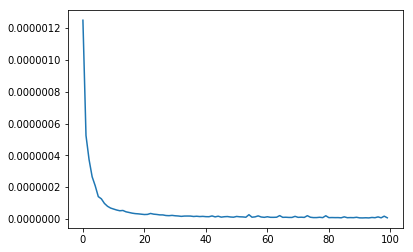

In [29]:
plt.plot(losses)
plt.show()

## Logistic Regression:

Looking at the new data:

In [30]:
y = y.reset_index()['loan_status']
x_encoded = pd.DataFrame(X_encoded[0])

In [31]:
encoded_data = pd.concat([x_encoded, y], axis = 1)

In [32]:
encoded_data.head()

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,loan_status
0,0.000022,0.194680,0.582618,0.661445,0.001795,0.008352,0.033367,0.059393,0.014808,0.000083,...,0.060017,0.039745,0.269230,0.230481,0.118529,0.037096,0.046716,0.349813,0.010032,0.0
1,0.006812,0.124862,0.576266,0.641342,0.001874,0.030043,0.069237,0.031617,0.016651,0.000026,...,0.106725,0.024807,0.311815,0.003986,0.131862,0.057509,0.050348,0.397344,0.009298,0.0
2,0.000052,0.289782,0.359574,0.606354,0.001671,0.052374,0.073409,0.035559,0.056307,0.000036,...,0.086620,0.060705,0.508742,0.131477,0.242725,0.045865,0.039863,0.434396,0.015203,0.0
3,0.005200,0.036624,0.376137,0.021453,0.131785,0.021650,0.026275,0.027049,0.034307,0.000034,...,0.209054,0.029836,0.410020,0.011509,0.189015,0.039510,0.058948,0.262742,0.001223,0.0
4,0.000388,0.031909,0.432001,0.233473,0.008213,0.012247,0.023729,0.024584,0.041685,0.000013,...,0.212298,0.050395,0.373707,0.051331,0.218108,0.038020,0.045333,0.238198,0.005773,0.0


In [33]:
encoded_data.shape

(100000, 173)

In [34]:
encoded_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,loan_status
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.406155e-03,0.135478,0.487751,0.419576,0.018426,0.031639,0.057641,0.028304,0.040453,5.180804e-02,...,0.103732,0.048185,0.385928,0.048647,0.185814,0.032023,0.050465,0.330674,0.012340,0.206220
std,7.367721e-03,0.095301,0.107140,0.259504,0.038950,0.015906,0.025650,0.013429,0.021750,1.811131e-01,...,0.048294,0.022789,0.072828,0.096853,0.078813,0.017570,0.023308,0.073328,0.009620,0.404592
min,1.180987e-07,0.000059,0.016474,0.006240,0.000226,0.000439,0.000598,0.000274,0.001178,5.732752e-11,...,0.009665,0.001508,0.012597,0.000278,0.010259,0.000529,0.000726,0.010093,0.000054,0.000000
25%,3.512324e-04,0.065497,0.407003,0.172923,0.001839,0.020110,0.039585,0.018701,0.025623,3.012697e-05,...,0.069918,0.031836,0.338282,0.004522,0.140297,0.019509,0.035044,0.279837,0.005120,0.000000
50%,2.093397e-03,0.105334,0.481545,0.433348,0.004221,0.028468,0.053807,0.025853,0.035991,9.501239e-05,...,0.092370,0.043720,0.382063,0.012009,0.170442,0.028993,0.046943,0.327266,0.010109,0.000000
75%,7.777967e-03,0.176125,0.569764,0.646646,0.014020,0.039688,0.071163,0.035167,0.050791,3.699411e-04,...,0.125298,0.059606,0.427151,0.039910,0.208445,0.041047,0.061558,0.376762,0.017110,0.000000
max,7.090362e-02,0.654592,0.856515,0.909651,0.480774,0.221873,0.367168,0.272428,0.771163,9.879813e-01,...,0.576459,0.333140,0.870905,0.772741,0.802140,0.364733,0.725720,0.857284,0.187329,1.000000


Save encoded data in output folder:

In [35]:
encoded_data.to_csv("../output/encoded_data_sample_100000.csv", sep = "^", index = False)

Run classifier with cross-validation and plot __ROC curves__:

In [37]:
cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression()

In [38]:
# dataframes to numpy arrays
X = x_encoded.values
y = y.values

The following source code to plot ROC curves have been downloaded from [sklearn API](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) with some metrics have been added for each cross validation split:

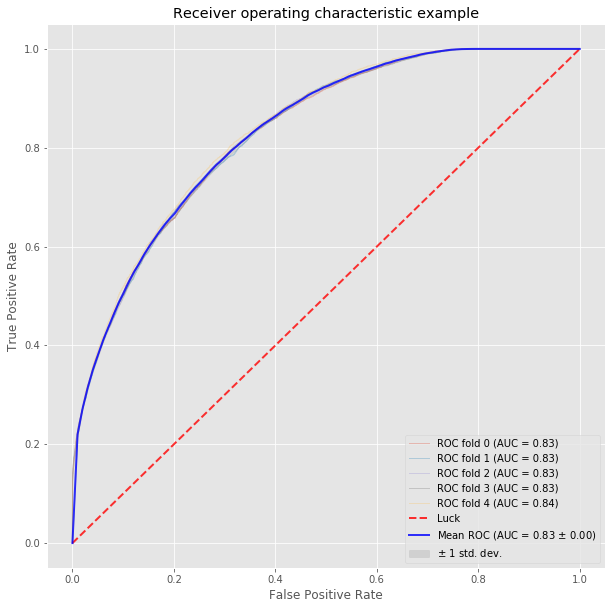

In [44]:
tprs = []
aucs = []
accuracies = []
precisions = []
recalls = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

i = 0
for train, test in cv.split(X, y):
    classifier.fit(X[train], y[train])
    probas_ = classifier.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    # accuracy
    predictions_ = classifier.predict(X[test])
    accuracy = accuracy_score(y[test], predictions_)
    accuracies.append(accuracy)
    
    # precisions
    precision = precision_recall_fscore_support(y[test], predictions_)[0][1]
    precisions.append(precision)
    
    # recall
    recall = precision_recall_fscore_support(y[test], predictions_)[1][1]
    recalls.append(recall)
    
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

__Metrics__ in the test set:

In [40]:
metrics = pd.DataFrame(
    {"auc": aucs,
     "accuracy": accuracies, 
     "precision": precisions, 
     "recall": recalls
    })

In [41]:
metrics

,accuracy,auc,precision,recall
0,0.835058,0.831338,0.725930,0.321697
1,0.833558,0.831403,0.715601,0.320242
2,0.834400,0.832800,0.727324,0.314985
3,0.834892,0.831225,0.729097,0.317168
4,0.835892,0.837427,0.738933,0.315713


In [42]:
metrics.apply(lambda i: np.mean(i), axis = 0)

accuracy     0.834760
auc          0.832839
precision    0.727377
recall       0.317961
dtype: float64

This is really the model that has obtained the best results (without hyperparameter tuning of the regularization value) although it is true that all the models have been tested with samples of the 25% of the data. We will see how the models perform with the total data.